# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>


### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**.

In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'STIXGeneral','font.size':'18','axes.formatter.use_mathtext':'True'})
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)
plt.rcParams.update({'font.family': 'cmr10','font.size':'15','axes.formatter.use_mathtext':'True','mathtext.fontset':'cm'})

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [3]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.

In [ ]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels)

#### Reshape data and convert labels to be used with categorical cross entropy

In [ ]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`.

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(512,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(128, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [9]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model(string_optimizer):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=string_optimizer,metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches.

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`.

In [ ]:
# training parameters
batch_size = 32
epochs = 5

# create the deep neural net
model_DNN = compile_model('SGD')

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=0,validation_data=(X_test, Y_test))

#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

 29/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9580 - loss: 0.1273 

2024-11-06 09:44:32.840432: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9460 - loss: 0.1721

Test loss: 0.14780153334140778
Test accuracy: 0.954800009727478


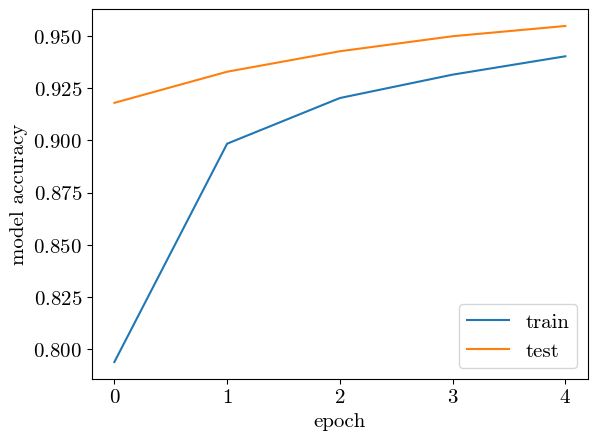

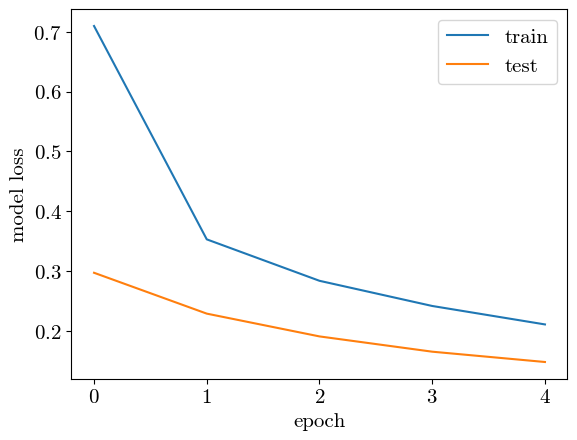

In [13]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


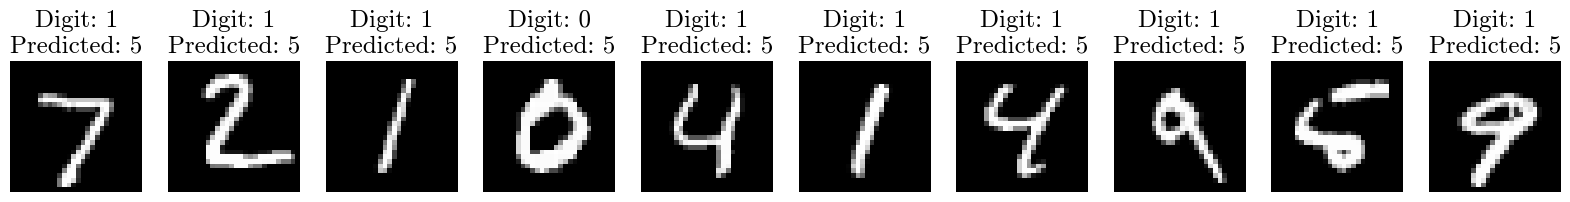

In [22]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(20, 15))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(X_test[i, :, :, 0], cmap='gray')
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))
    plt.axis('off')
plt.show()

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

## Solution 12.1

### Problems approach
From the prveiouos datasets is clear that a DNN with two layers of $512$ and $128$ neurons (with activation function relu in the first two layers and softmax in the last one) is a good architecture for this number recognition problem.
To find the best optimizer I have trained the model with different optimizers and saved the losses and the accuracies.
- In the following cell is shown the code for the search of the best hyperparameters.

In [ ]:
from keras.datasets import mnist
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Sequential
from keras.layers import Dense, Dropout

'''
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels
# output
num_classes = 10 # 10 digits
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()
# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(512,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(128, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

print('Model architecture created successfully!')

def compile_model(string_optimizer):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=string_optimizer,metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')
# training parameters
batch_size = 32
epochs = 20
optimizers=['SGD', 'Adam', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
for optimizer in optimizers:
    print('Optimizer: ', optimizer)
    # create the deep neural net
    model_DNN = compile_model(optimizer)
    # train DNN and store training info in history
    history = model_DNN.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=0,validation_data=(X_test, Y_test))
    # evaluate model
    score = model_DNN.evaluate(X_test, Y_test, verbose=1)
    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print()
    np.savetxt('losses_'+optimizer+'.txt', history.history['loss'])
    np.savetxt('accuracies_'+optimizer+'.txt', history.history['acc'])
    np.savetxt('val_losses_'+optimizer+'.txt', history.history['val_loss'])
    np.savetxt('val_accuracies_'+optimizer+'.txt', history.history['val_acc'])
    '''

### Print results
Saved all the losses and accuracies i have make a plot to compare the results:

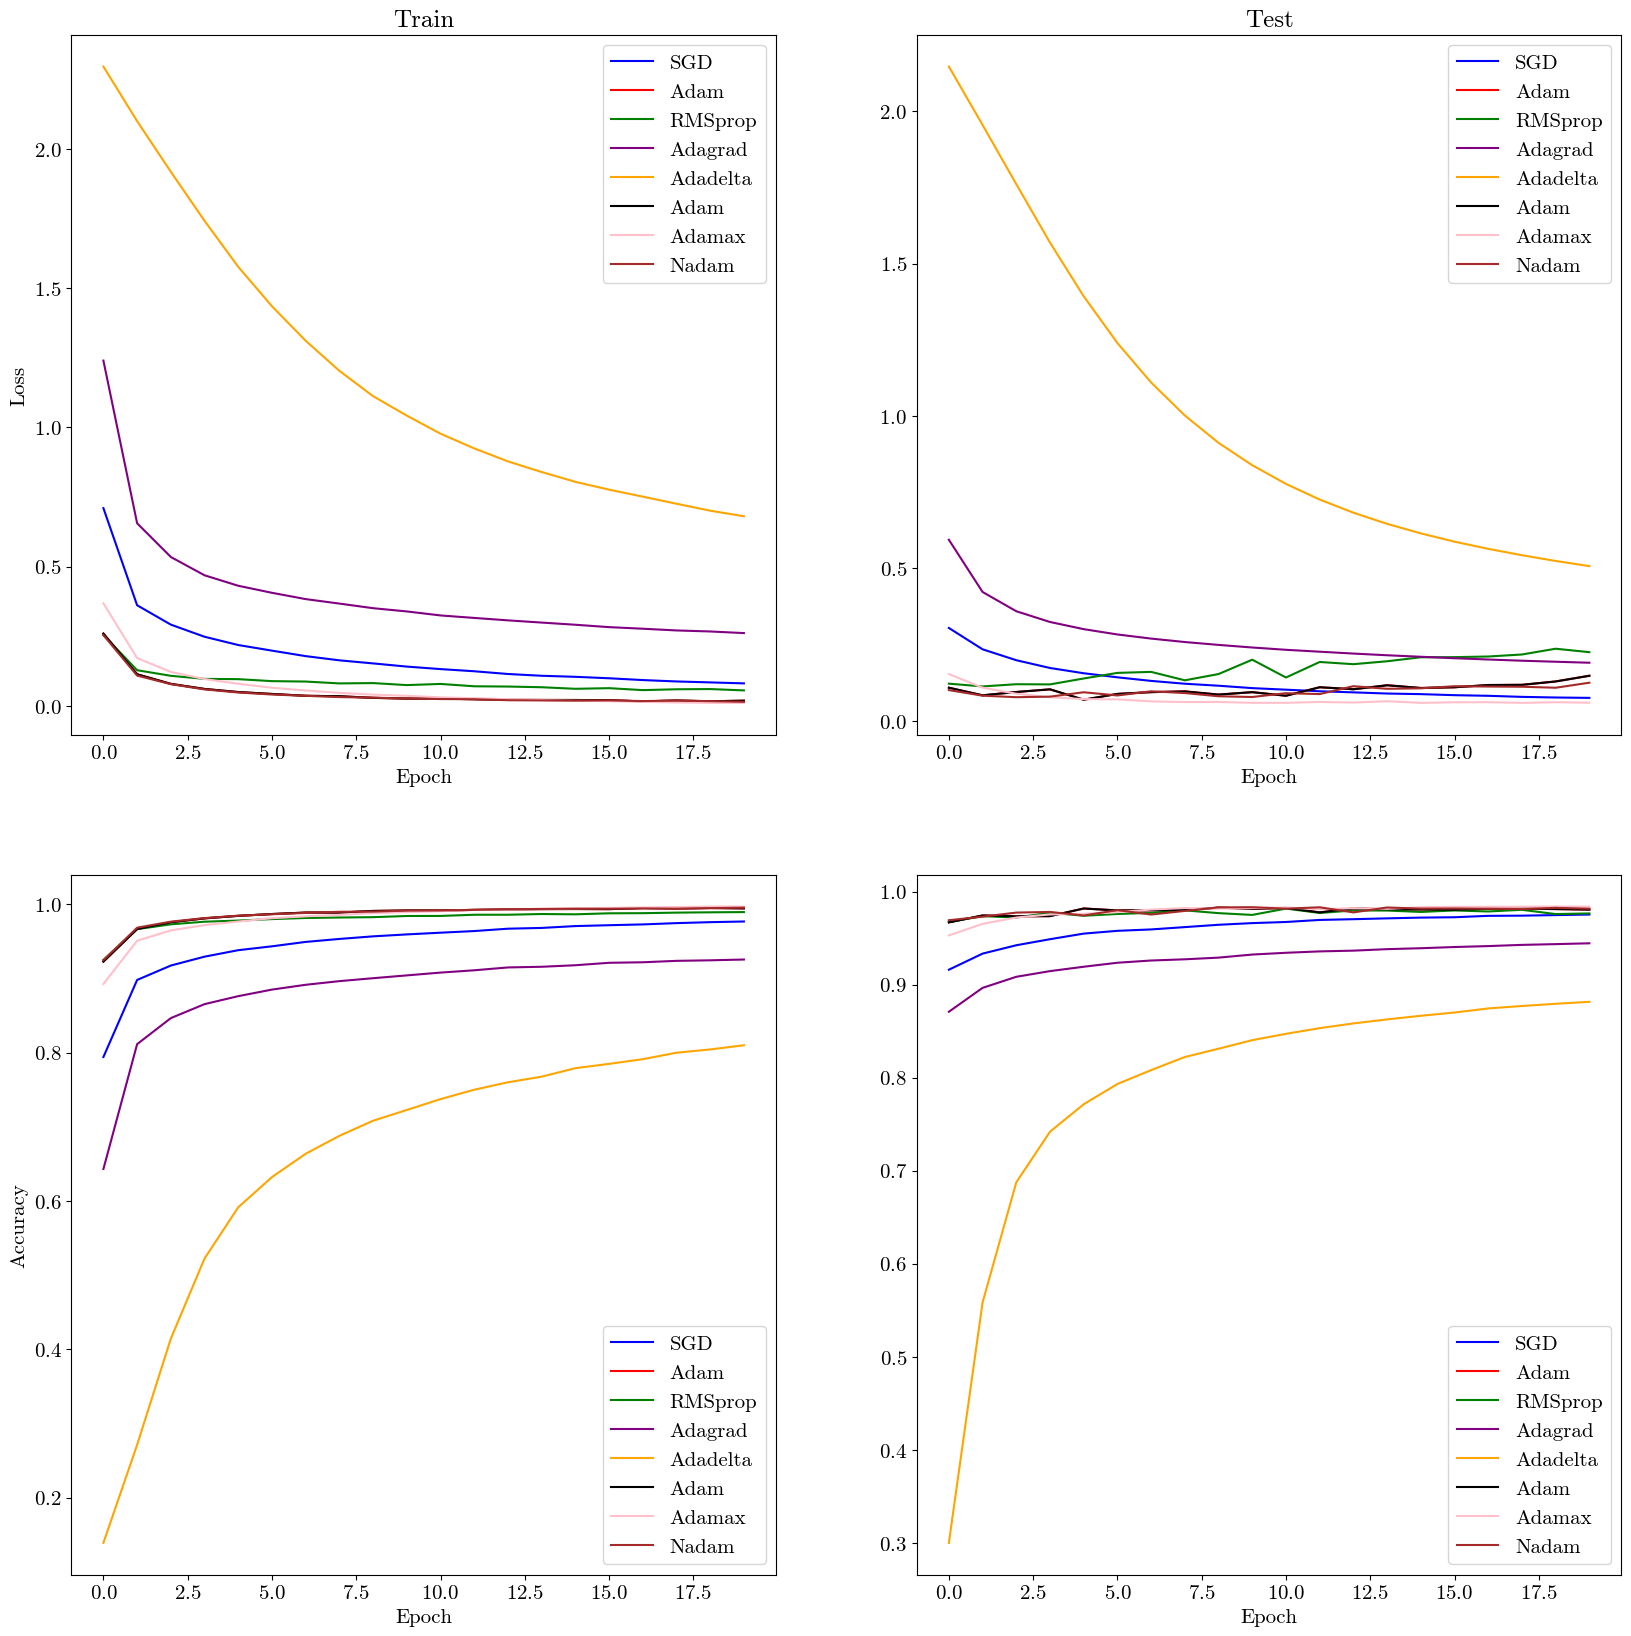

In [23]:
optimizers=['SGD', 'Adam', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
colors=['blue', 'red', 'green', 'purple', 'orange', 'black', 'pink', 'brown']
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
for optimizer,color in zip(optimizers,colors):
    loss=np.loadtxt('../lecture_12/Results/losses_'+optimizer+'.txt')
    accuracy=np.loadtxt('../lecture_12/Results/accuracies_'+optimizer+'.txt')
    val_loss=np.loadtxt('../lecture_12/Results/val_losses_'+optimizer+'.txt')
    val_accuracy=np.loadtxt('../lecture_12/Results/val_accuracies_'+optimizer+'.txt')
    axs[0, 0].set_title("Train")
    axs[0, 0].plot(loss, label=optimizer,color=color)
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
 
    axs[0, 1].set_title("Test")
    axs[0, 1].plot(val_loss, label=optimizer,color=color)
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend()

    axs[1, 0].plot(accuracy, label=optimizer,color=color)
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].legend()

    axs[1, 1].plot(val_accuracy, label=optimizer,color=color)
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend()
    
    



### Results
- As we can see the best optimizers are *Nadam*, *Adam*, *Adamax* while *Adadelta* and *Adagrad* are the worse one. The reason might be that *Nadam*, *Adam*, *Adamax* use adaptive learining rates combined with momentum while *Adagrad* adapts the learning rate based on accumulation of past gradients, which can slow down the convergence if the dataset is big. *Adagrad* try to solve this problem but with complex architectures might struggle with convergence.

### Train the DNN with Adamax

In [ ]:
from keras.datasets import mnist
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Sequential
from keras.layers import Dense, Dropout
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(512,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(128, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

def compile_model(string_optimizer):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=string_optimizer,metrics=['acc'])
    return model
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels
# output
num_classes = 10 # 10 digits
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()
# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
# training parameters
batch_size = 32
epochs = 5
# create the deep neural net
model_DNN = compile_model('Adamax')
# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=0,validation_data=(X_test, Y_test))

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

In [3]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D

# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000,)

60000 train samples
10000 test samples


One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

## Solution Exercise 12.2

### Problems theory
- A Convolutional Neural Network (CNN) is a neural network tailored for visual data, capturing spatial hierarchies within images for tasks like classification. Key layers include **Conv2D**, which uses filters to detect patterns (e.g., edges), **Max Pooling**, which downsamples feature maps to reduce complexity and highlight dominant features, and Flatten, which transforms spatial features into a single vector for classification. This layered structure allows CNNs to learn progressively complex patterns, making them highly effective for visual recognition tasks.
- **Padding** refers to adding extra pixels (usually zeros) around the input image's borders before applying a convolution. This helps preserve spatial dimensions in the output, preventing the image size from shrinking with each layer and enabling edge features to be detected.
- **Pool Size** is the window size used in pooling layers (e.g., Max Pooling). It defines the area over which the pooling operation (like taking the max value) is applied. Common sizes are 2x2 or 3x3, which reduce the dimensions by selecting the most prominent features in each window.

### Problems approach
- The CNN created is composed by 4 pairs of Conv2D followed by Maxpooling layers. Then the Flatten layers transform all the data in a 1D layer so to process the vector in a DNN composed by two layers of 128 and 32 neurons with activation function relu

In [25]:
# you will need the following for Convolutional Neural Networks
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Sequential
from keras.layers import Dense, Dropout

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels
# output
num_classes = 10 # 10 digits
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

#THIS IS INCOMPLETE ... COMPLETE BEFORE EXECUTING IT

def create_CNN(optimizer):
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # First Conv2D layer with padding and a MaxPooling layer
    model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Seconf Conv2D layer, Dropout, and MaxPooling
    model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Third Conv2D layer, Dropout, and MaxPooling
    model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Flatten the feature maps into a 1D vector
    model.add(Flatten())
    # Fully connected layer (Dense layer)
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    # Output layer with 10 units (for 10 classes), using softmax activation
    model.add(Dense(10, activation='softmax'))

    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=optimizer,metrics=['acc'])
    return model

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


Train your DCNN and evaluate its performance proceeding exactly as before:

In [13]:
# CODE TO FIND THE BEST OPTIMIZER
'''
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels
# output
num_classes = 10 # 10 digits
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
print('Model architecture created successfully!')

def compile_model(string_optimizer):
    # create the model
    model=create_CNN(string_optimizer)
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=string_optimizer,metrics=['acc'])
    return model

def create_CNN(optimizer):
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # First Conv2D layer with padding and a MaxPooling layer
    model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Seconf Conv2D layer, Dropout, and MaxPooling
    model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Third Conv2D layer, Dropout, and MaxPooling
    model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Flatten the feature maps into a 1D vector
    model.add(Flatten())
    # Fully connected layer (Dense layer)
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    # Output layer with 10 units (for 10 classes), using softmax activation
    model.add(Dense(10, activation='softmax'))
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=optimizer,metrics=['acc'])
    return model
    
print('Model compiled successfully and ready to be trained.')
# training parameters
batch_size = 32
epochs = 10
optimizers=['SGD', 'Adam', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
for optimizer in optimizers:
    print('Optimizer: ', optimizer)
    # create the deep neural net
    model_CNN = compile_model(optimizer)
    # train DNN and store training info in history
    history = model_CNN.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=0,validation_data=(X_test, Y_test))
    # evaluate model
    score = model_CNN.evaluate(X_test, Y_test, verbose=1)
    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print()
    np.savetxt('../lecture_12/Results/CNN_losses_'+optimizer+'.txt', history.history['loss'])
    np.savetxt('../lecture_12/Results/CNN_accuracies_'+optimizer+'.txt', history.history['acc'])
    np.savetxt('../lecture_12/Results/CNN_val_losses_'+optimizer+'.txt', history.history['val_loss'])
    np.savetxt('../lecture_12/Results/CNN_val_accuracies_'+optimizer+'.txt', history.history['val_acc'])
    '''

Model architecture created successfully!
Model compiled successfully and ready to be trained.
Optimizer:  SGD
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.9850 - loss: 0.0619

Test loss: 0.05283651873469353
Test accuracy: 0.9866999983787537

Optimizer:  Adam
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.9916 - loss: 0.0475

Test loss: 0.03965989872813225
Test accuracy: 0.9925000071525574

Optimizer:  RMSprop
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - acc: 0.9794 - loss: 0.1526

Test loss: 0.12375146150588989
Test accuracy: 0.9829999804496765

Optimizer:  Adagrad
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - acc: 0.9255 - loss: 0.3493

Test loss: 0.30890849232673645
Test accuracy: 0.9354000091552734

Optimizer:  Adadelta
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - acc: 0.1715 - loss: 2.2824

Test loss: 2.2811594009399414
Test accuracy: 0.16619999706745148

Optimizer:  Adam
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - acc: 0.9892 - loss: 0.0494

Test loss: 0.0415857769548893
Test acc

### Plot of the optimizers for CNN
Saved all the losses and accuracies i have make a plot to compare the results:

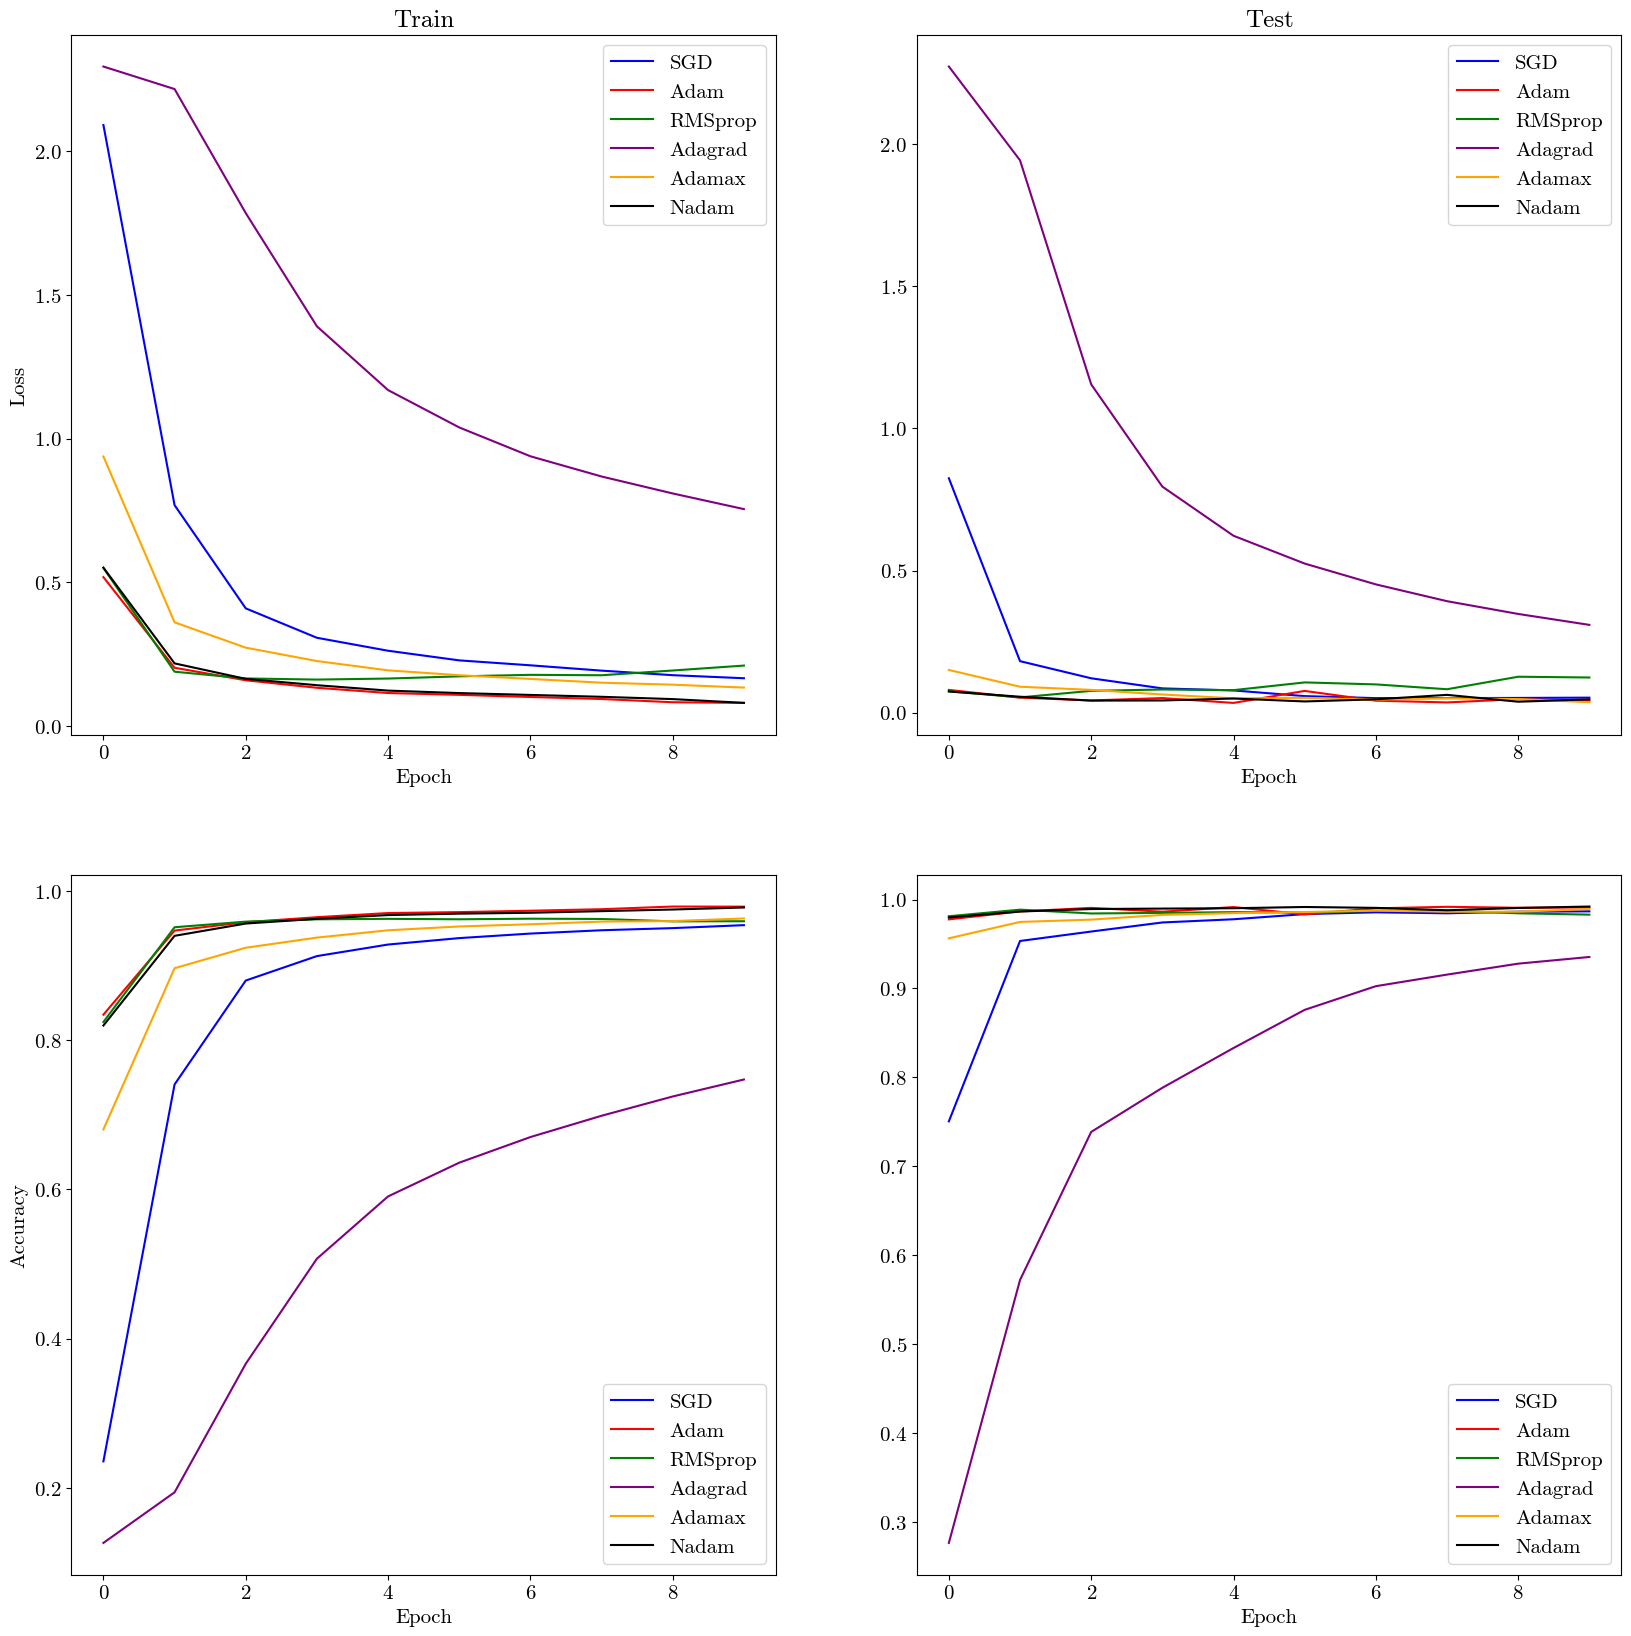

In [5]:

optimizers=['SGD', 'Adam', 'RMSprop', 'Adagrad', 'Adamax', 'Nadam']
colors=['blue', 'red', 'green', 'purple', 'orange', 'black', 'pink', 'brown']
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
for optimizer,color in zip(optimizers,colors):
    loss=np.loadtxt('../lecture_12/Results/CNN_losses_'+optimizer+'.txt')
    accuracy=np.loadtxt('../lecture_12/Results/CNN_accuracies_'+optimizer+'.txt')
    val_loss=np.loadtxt('../lecture_12/Results/CNN_val_losses_'+optimizer+'.txt')
    val_accuracy=np.loadtxt('../lecture_12/Results/CNN_val_accuracies_'+optimizer+'.txt')
    axs[0, 0].set_title("Train")
    axs[0, 0].plot(loss, label=optimizer,color=color)
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
 
    axs[0, 1].set_title("Test")
    axs[0, 1].plot(val_loss, label=optimizer,color=color)
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend()

    axs[1, 0].plot(accuracy, label=optimizer,color=color)
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].legend()

    axs[1, 1].plot(val_accuracy, label=optimizer,color=color)
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend()
    
    



- As we can see the best optimizers is are Adam, Adamax, NAdam. While the worse ones are Adadelta,
### Compile the model with Adamax

In [26]:
def compile_model(string_optimizer):
    # create the model
    model=create_CNN(string_optimizer)
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=string_optimizer,metrics=['acc'])
    return model

def create_CNN(optimizer):
    # instantiate model
    model = Sequential()
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # First Conv2D layer with padding and a MaxPooling layer
    model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Seconf Conv2D layer, Dropout, and MaxPooling
    model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Third Conv2D layer, Dropout, and MaxPooling
    model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # Flatten the feature maps into a 1D vector
    model.add(Flatten())
    # Fully connected layer (Dense layer)
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    # Output layer with 10 units (for 10 classes), using softmax activation
    model.add(Dense(10, activation='softmax'))
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=optimizer,metrics=['acc'])
    return model
# training parameters
batch_size = 32
epochs = 10

# create the deep conv net
model_CNN=create_CNN('Adam')

# train CNN
history=model_CNN.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,verbose=0,validation_data=(X_test, Y_test))

# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=0)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/home/scaio/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Test loss: 0.04341308772563934
Test accuracy: 0.9907000064849854


In the end, **<span style="color:red">add the evaluation of your CNN performances</span>** like that used for the DNN.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.9881 - loss: 0.0573

Test loss: 0.04341308772563934
Test accuracy: 0.9907000064849854


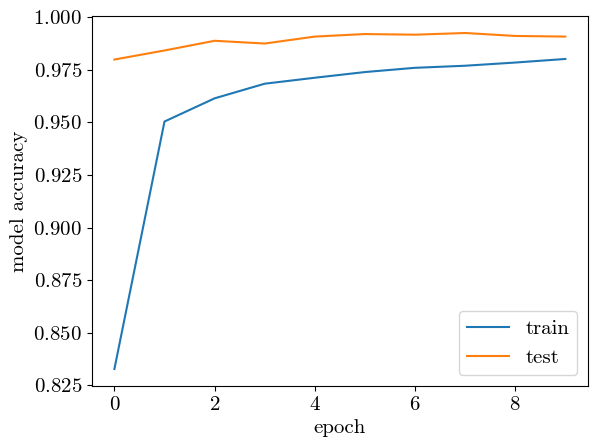

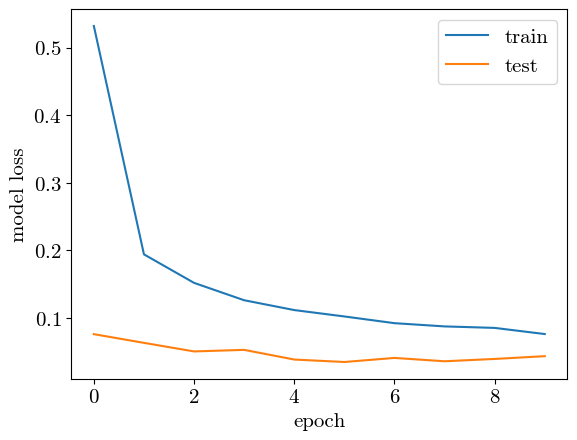

In [27]:
import matplotlib.pyplot as plt
# evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

For example, you can use the following code to import a picture of an handwritten digit
(Note: you should install Python Image Library (PIL/Pillow):

DNN to prediction of the digit:

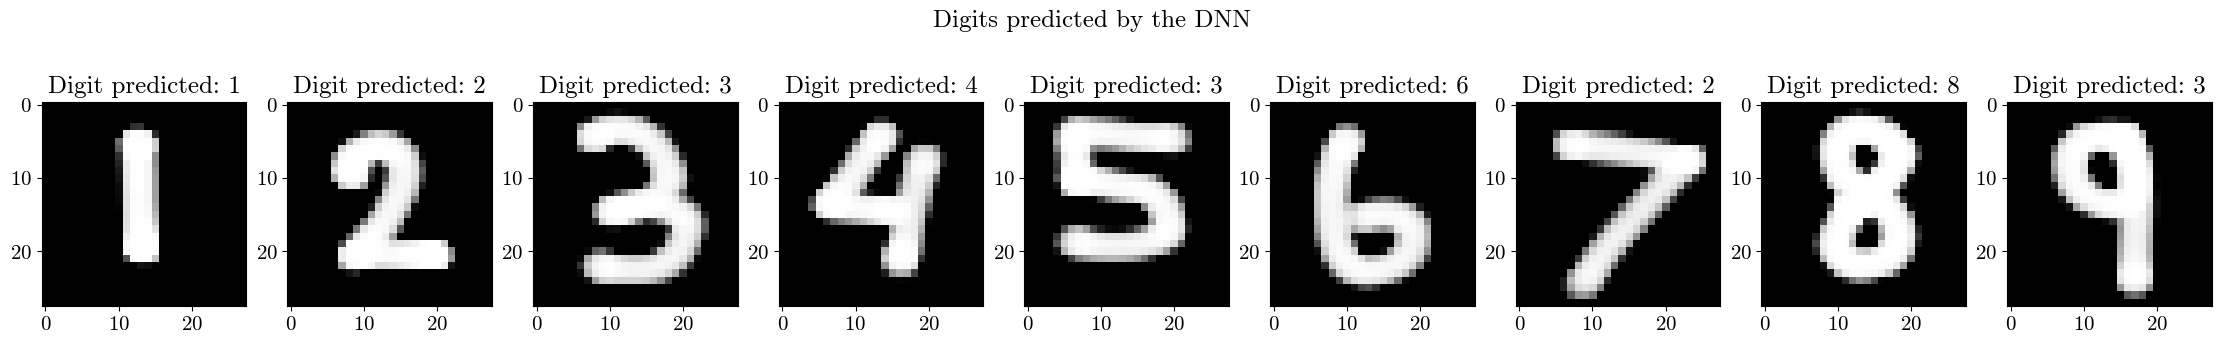

In [38]:
from PIL import Image
import os

fig, ax = plt.subplots(1, 9, figsize=(28,4))
fig.suptitle('Digits predicted by the DNN')
numbers=['one.png', 'two.png', 'three.png', 'four.png', 'five.png', 'six.png', 'seven.png', 'eight.png', 'nine.png']
path = '../lecture_12/Results/numbers/'

for k,number in zip(range(10),numbers):
    digit_filename = path+number
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255
    ax[k].imshow(data, cmap='gray')
    data = data.reshape(1,xdim*ydim)
    pred_0 = model_DNN.predict(data,verbose=0)
    ax[k].set_title("Digit predicted: {}".format(np.argmax(pred_0)))
plt.show()

CNN prediction of the digit

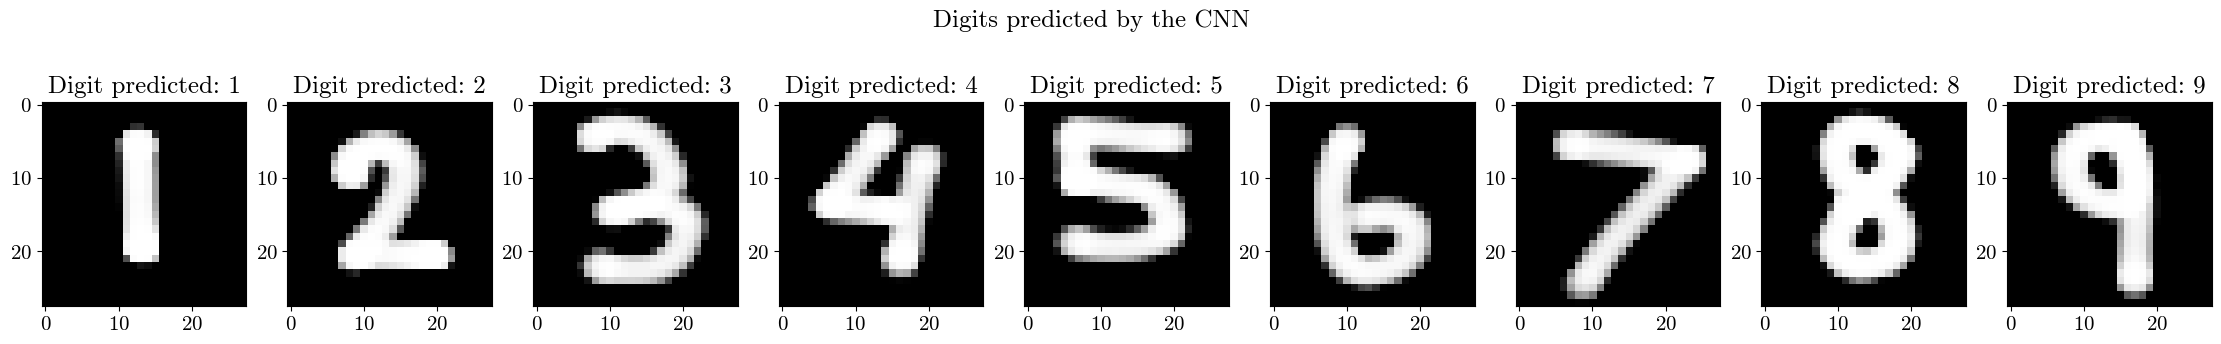

In [39]:
from PIL import Image
import os

fig, ax = plt.subplots(1, 9, figsize=(28,4))
fig.suptitle('Digits predicted by the CNN')
numbers=['one.png', 'two.png', 'three.png', 'four.png', 'five.png', 'six.png', 'seven.png', 'eight.png', 'nine.png']
path = '../lecture_12/Results/numbers/'

for k,number in zip(range(10),numbers):
    digit_filename = path+number
    digit_in = Image.open(digit_filename).convert('L')
    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255
    ax[k].imshow(data, cmap='gray')
    data = data.reshape(1,xdim,ydim)
    pred_0 = model_CNN.predict(data,verbose=0)
    ax[k].set_title("Digit predicted: {}".format(np.argmax(pred_0)))
plt.show()

### Results

- The Deep Neural Network (DNN) struggles to accurately predict the numbers I wrote, whereas the Deep Convolutional Neural Network (DCNN) correctly identifies them. This difference in performance may be due to the DCNN's ability to handle **locality** and **translational invariance**. Unlike the DNN, the DCNN can capture local features consistently, so even if each number is written with slight variations, the local features remain similar, allowing the DCNN to recognize the numbers more effectively.
